In [23]:
# General

import numpy as np
import pandas as pd
import re
import os
import pickle

# EDA

import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud
from collections import Counter

# NLP 

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

# ML

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

In [48]:
df = pd.read_csv("spam.csv", encoding = 'latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


## Dropping unwanted columns

In [49]:
df.drop(df.columns[[2,3,4]], axis = 1, inplace = True)
df.columns = ['target','SMS']
df.head()

,target,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [50]:
df['no_of_chars'] = df['SMS'].apply(len)
df['no_of_words'] = df['SMS'].apply(lambda x: len(nltk.word_tokenize(x)))
df['no_of_sents'] = df['SMS'].apply(lambda x: len(nltk.sent_tokenize(x)))
df['Label'] = df['target'].map({'ham': 0, 'spam': 1})

df.head()


,target,SMS,no_of_chars,no_of_words,no_of_sents,Label
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2,0
1,ham,Ok lar... Joking wif u oni...,29,8,2,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,1
3,ham,U dun say so early hor... U c already then say...,49,13,1,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1,0


### EDA

In [55]:
temp = pd.DataFrame()
temp['Target'] = ['Ham','Spam']
temp['Count'] = [len(df[df['target'] == 'ham']), len(df[df['target'] == 'spam'])]
temp = temp.sort_values(by = ['Count'], ascending = False)
fig = px.pie(temp, values = 'Count', names = 'Target', width = 600, 
             color = 'Target', color_discrete_map = {'Ham': 'rgb(124, 224, 24)', 'Spam': 'rgb(228, 26, 28)'},
             template = 'simple_white', title = "Count of Spam and Ham Messages ")
fig.show()

In [56]:
fig = px.histogram(df, x = 'no_of_chars', color = 'target', 
                   template = 'simple_white', 
                   title = "Histogram for HAM vs SPAM based on Number of Characters per Message")

fig.update_xaxes(showgrid = False)
fig.update_yaxes(showgrid = False)
fig.update_layout(barmode = 'overlay')
fig.show()

/Users/manojkumarpotnuru/anaconda3/lib/python3.11/site-packages/plotly/express/_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [59]:
fig = px.histogram(df, x = 'no_of_words', color = 'target', 
                   template = 'simple_white', 
                   title = "Histogram for HAM vs SPAM based on Number of Words per Message")

fig.update_xaxes(showgrid = False)
fig.update_yaxes(showgrid = False)
fig.update_layout(barmode = 'overlay')
fig.show()

/Users/manojkumarpotnuru/anaconda3/lib/python3.11/site-packages/plotly/express/_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [60]:
fig = px.histogram(df, x = 'no_of_sents', color = 'target', template = 'simple_white', title = "Histogram for HAM vs SPAM based on Number of Sentences per Message")
fig.update_xaxes(showgrid = False)
fig.update_yaxes(showgrid = False)
fig.update_layout(barmode = 'overlay')
fig.show()

/Users/manojkumarpotnuru/anaconda3/lib/python3.11/site-packages/plotly/express/_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [73]:
def word_count_plot(data, title):
    word_counter = Counter([word for sentence in data for word in sentence.split()])
    most_count = word_counter.most_common(25)
    most_count = pd.DataFrame(most_count, columns = ['Word', 'Count']).sort_values(by = "Count")
    most_count = most_count.sort_values(by = 'Count', ascending = False)
    
    fig = px.bar(most_count, x = 'Word', y = 'Count', color = "Count", text_auto = '', template = 'plotly_dark', title = title)
    fig.update_xaxes(showgrid = False)
    fig.update_yaxes(showgrid = False, showticklabels = False)
    fig.update_traces(textfont_size = 12, textangle = 0, textposition = "outside", cliponaxis = False)
    fig.show()

In [101]:
word_count_plot(df["SMS"], "Word Count Plot Before Preprocessing")

## Preprocessing text

In [61]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
 
 
# Preprocess text data
def preprocess_text(text):
    # Tokenization: Split text into words
    words = text.split()
 
    # Lowercasing: Convert to lowercase
    words = [word.lower() for word in words]
 
    # Removing Special Characters and Stopwords
    words = [re.sub(r'[^a-zA-Z0-9]', '', word) for word in words if word not in stopwords.words('english')]
 
    # Join the words back into a single string
    preprocessed_text = ' '.join(words)
 
    return preprocessed_text
 
# Apply text preprocessing to the "v2" column (your SMS messages)
df['Preprocessed_Text'] = df['SMS'].apply(preprocess_text)
 
# Display the first few rows to check the preprocessed data
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/manojkumarpotnuru/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,target,SMS,no_of_chars,no_of_words,no_of_sents,Label,Preprocessed_Text
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2,0,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,29,8,2,0,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,1,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,49,13,1,0,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1,0,nah think goes usf lives around though


In [70]:
tfidf = TfidfVectorizer(max_features = 3000)
X = tfidf.fit_transform(df['Preprocessed_Text']).toarray()
vocabulary_size = len(tfidf.vocabulary_)
print(X.shape)
print(tfidf.get_feature_names_out())
print("Vocabulary size:", vocabulary_size)
Y = df['Label'].values

(5572, 3000)
['020603' '07xxxxxxxxx' '0800' ... 'yuo' 'yup' 'zed']
Vocabulary size: 3000


In [72]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
 
nltk.download('punkt')
 
df['Tokenized_Text'] = df['Preprocessed_Text'].apply(word_tokenize)
 
# Train Word2Vec model on the tokenized text
word2vec_model = Word2Vec(df['Tokenized_Text'], vector_size=100, window=5, min_count=1, sg=0)
 
# Function to calculate the average word embedding for a sentence
def average_word_embedding(tokens):
    embeddings = [word2vec_model.wv[word] for word in tokens if word in word2vec_model.wv]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)
    
df['Word_Embeddings'] = df['Tokenized_Text'].apply(average_word_embedding)
df.head()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/manojkumarpotnuru/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,target,SMS,no_of_chars,no_of_words,no_of_sents,Label,Preprocessed_Text,Tokenized_Text,Word_Embeddings
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2,0,go jurong point crazy available bugis n great ...,"[go, jurong, point, crazy, available, bugis, n...","[-0.12278812, 0.19662645, 0.063306555, 0.03213..."
1,ham,Ok lar... Joking wif u oni...,29,8,2,0,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]","[-0.13931242, 0.22652186, 0.07158622, 0.043565..."
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,1,free entry 2 wkly comp win fa cup final tkts 2...,"[free, entry, 2, wkly, comp, win, fa, cup, fin...","[-0.10697384, 0.1729423, 0.050911173, 0.025496..."
3,ham,U dun say so early hor... U c already then say...,49,13,1,0,u dun say early hor u c already say,"[u, dun, say, early, hor, u, c, already, say]","[-0.19987091, 0.32907224, 0.099485055, 0.05746..."
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1,0,nah think goes usf lives around though,"[nah, think, goes, usf, lives, around, though]","[-0.083286576, 0.13705134, 0.04584185, 0.02060..."


### Word Cloud Analysis on Corpus for Spam Messages


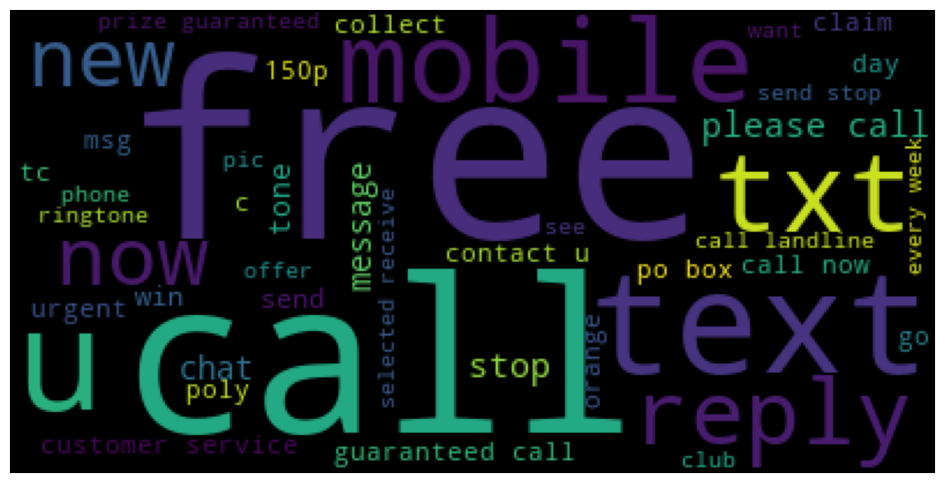

In [109]:
plt.figure(figsize = (24, 6))
wc = WordCloud(min_font_size = 10, background_color = 'black')
spam_wc = wc.generate(df[df['target'] == 'spam']['Preprocessed_Text'].str.cat(sep = " "))
plt.xticks([])
plt.yticks([])
plt.imshow(spam_wc);

### Word Cloud Analysis on Corpus for Ham Messages

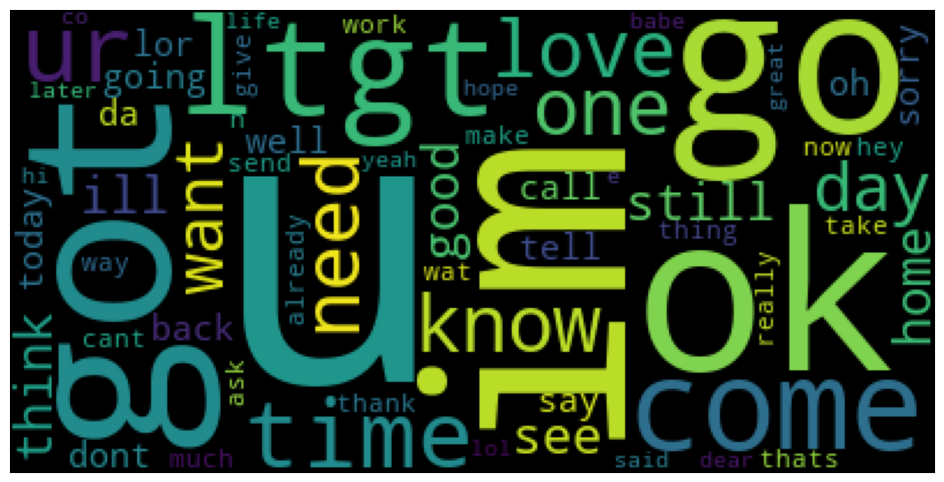

In [107]:
plt.figure(figsize = (24, 6))
wc = WordCloud(min_font_size = 10, background_color = 'black')
ham_wc = wc.generate(df[df['target'] == 'ham']['Preprocessed_Text'].str.cat(sep = " "))
plt.xticks([])
plt.yticks([])
plt.imshow(ham_wc);

### Data Modeling


Train Test Split


In [76]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(4457, 3000) (1115, 3000) (4457,) (1115,)


### Evaluation Metrics 

In [78]:
def evaluation_parametrics(name, y_train, yp_train, y_test, yp_test):
    
    print("\n-----------------------------{}-----------------------------\n".format(name))
          
    cm_test = confusion_matrix(y_test, yp_test)
    t = ConfusionMatrixDisplay(cm_test)
    s = round((cm_test[0,0]/(cm_test[0,0] + cm_test[0,1])),4)
    
    print("\nClassification Report for Test Data\n")
    print(classification_report(y_test, yp_test))   
    print("--------------------------------------------------------------------------")
    print("Accuracy on Test Data: ", round(accuracy_score(y_test, yp_test), 4))
    print("F1 Score Test Data: ", round(f1_score(y_test, yp_test), 4))
    print("--------------------------------------------------------------------------")
    
    t.plot()

### Naive Bayes Classifier



-----------------------------Naive Bayes Classifier-----------------------------


Classification Report for Test Data

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       1.00      0.84      0.91       150

    accuracy                           0.98      1115
   macro avg       0.99      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115

--------------------------------------------------------------------------
Accuracy on Test Data:  0.9785
F1 Score Test Data:  0.913
--------------------------------------------------------------------------


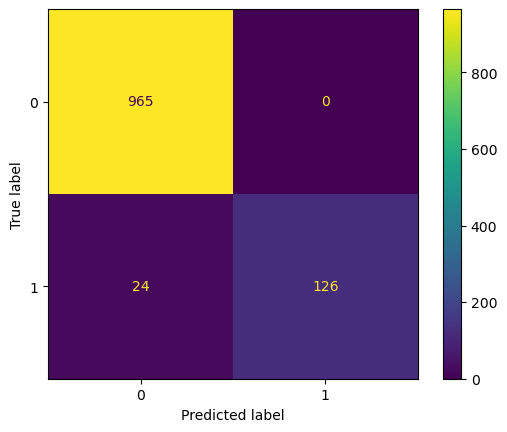

In [79]:
nb = MultinomialNB()
nb.fit(x_train, y_train)

yp_train = nb.predict(x_train)
yp_test = nb.predict(x_test)

evaluation_parametrics("Naive Bayes Classifier", y_train, yp_train, y_test, yp_test)


-----------------------------Decision tree Classifier-----------------------------


Classification Report for Test Data

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       965
           1       0.85      0.82      0.83       150

    accuracy                           0.96      1115
   macro avg       0.91      0.90      0.90      1115
weighted avg       0.96      0.96      0.96      1115

--------------------------------------------------------------------------
Accuracy on Test Data:  0.9561
F1 Score Test Data:  0.8339
--------------------------------------------------------------------------


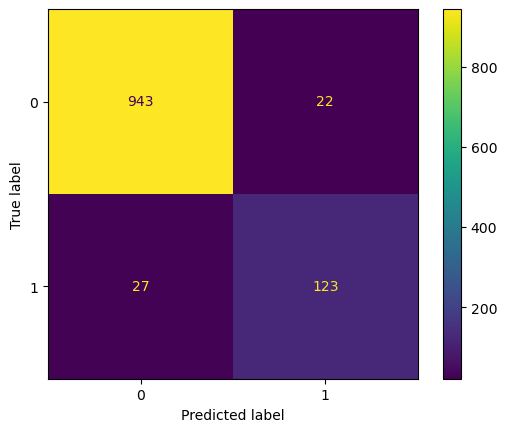

In [80]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier()
classifier.fit(x_train, y_train)

yp_train = classifier.predict(x_train)
yp_test = classifier.predict(x_test)

evaluation_parametrics("Decision tree Classifier", y_train, yp_train, y_test, yp_test)

In [110]:
#pip install numpy tensorflow scikit-learn


In [89]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
 

tokenizer = Tokenizer(num_words=5000)  
tokenizer.fit_on_texts(df['Preprocessed_Text'])
 

X = tokenizer.texts_to_sequences(df['Preprocessed_Text'])
 
X = pad_sequences(X, maxlen=3000)  
 
Y = df['Label'].values

In [90]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
 
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=50, input_length=3000))  
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
 
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [91]:
model.fit(x_train, y_train, batch_size=32, epochs=5, validation_split=0.1)


Epoch 1/5
126/126 [==============================] - 227s 2s/step - loss: 0.4173 - accuracy: 0.8631 - val_loss: 0.4208 - val_accuracy: 0.8565
Epoch 2/5
126/126 [==============================] - 220s 2s/step - loss: 0.3953 - accuracy: 0.8671 - val_loss: 0.4135 - val_accuracy: 0.8565
Epoch 3/5
126/126 [==============================] - 202s 2s/step - loss: 0.3935 - accuracy: 0.8671 - val_loss: 0.4113 - val_accuracy: 0.8565
Epoch 4/5
126/126 [==============================] - 199s 2s/step - loss: 0.3932 - accuracy: 0.8671 - val_loss: 0.4145 - val_accuracy: 0.8565
Epoch 5/5
126/126 [==============================] - 218s 2s/step - loss: 0.3931 - accuracy: 0.8671 - val_loss: 0.4133 - val_accuracy: 0.8565


In [92]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

35/35 [==============================] - 6s 174ms/step - loss: 0.3956 - accuracy: 0.8655
Test Accuracy: 0.8655


In [98]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
 
# Assuming df['Preprocessed_Text'] contains the preprocessed text
vectorizer = CountVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(df['Preprocessed_Text'])
# Set the number of topics
n_components = 15
 
lda = LatentDirichletAllocation(n_components=n_components, random_state=42)
lda.fit(X)
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = f"Topic #{topic_idx+1}: "
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
        print()
 
# Print the top words in each topic
print_top_words(lda, vectorizer.get_feature_names_out(), n_top_words=10)
# Assign the highest probability topic to each document
topic_results = lda.transform(X)
df['Topic'] = topic_results.argmax(axis=1) + 1  # Add 1 to make topics 1-indexed
print(df[['Preprocessed_Text', 'Topic']])
# Optionally, save the updated DataFrame to a CSV file
df.to_csv('updated_dataframe_with_topics.csv', index=False)

Topic #1: ok care pick thanx problem ur tell good prize time

Topic #2: ill sorry later cash hey holiday win customer 5000 sae

Topic #3: im like ltgt time today work love think leave late

Topic #4: ya say love class boy good wait dinner girl da

Topic #5: lor wat da got wan buy thk dun eat meet

Topic #6: said new amp try im ltgt xmas years told sat

Topic #7: going ur got im cos da today shopping way lei

Topic #8: ltgt ur ill im great send need life week thanks

Topic #9: number claim code account award selected receive shows points mobile

Topic #10: want ask lor sure ill home tonight fine aight like

Topic #11: good happy ur dear contact morning prize day claim urgent

Topic #12: pls free message send ur txt birthday week phone sent

Topic #13: free reply stop mobile text new msg ur mins latest

Topic #14: im hi come home yeah day tomorrow ill gonna ur

Topic #15: know let time need got love text dont ive stop

                                      Preprocessed_Text  Topic
0     

In [100]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
 
# Assuming you have already loaded and preprocessed your SMS data in the 'df' DataFrame
# ...
 
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=3000)  # You can adjust max_features
X_tfidf = tfidf_vectorizer.fit_transform(df['Preprocessed_Text'])
y = df['Label']
 
# Train a Multinomial Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_tfidf, y)
 
# Get the feature names (terms)
feature_names = tfidf_vectorizer.get_feature_names_out()
 
# Get the log probabilities of features for each class (spam and non-spam)
log_probabilities = nb_classifier.feature_log_prob_
 
# Calculate the difference in log probabilities (indicative of spam vs. non-spam)
log_probability_difference = log_probabilities[1] - log_probabilities[0]
 
# Create a DataFrame to store feature names and their log probability differences
feature_analysis_df = pd.DataFrame({'Feature': feature_names, 'LogProbabilityDifference': log_probability_difference})
 
# Sort the features by log probability difference in descending order
feature_analysis_df = feature_analysis_df.sort_values(by='LogProbabilityDifference', ascending=False)
 
# Display the top N features indicative of spam
top_n = 20  # You can adjust this to see more or fewer features
top_spam_features = feature_analysis_df.head(top_n)
print(f'Top {top_n} features indicative of spam:')
print(top_spam_features)


Top 20 features indicative of spam:
         Feature  LogProbabilityDifference
600        claim                  4.167620
2043       prize                  4.047327
1159  guaranteed                  3.532841
31          1000                  3.413694
61            18                  3.360135
123          500                  3.336352
2685        tone                  3.336214
345      awarded                  3.295466
2768      urgent                  3.283504
58        150ppm                  3.203542
50           150                  3.195776
2214    ringtone                  3.169936
60            16                  3.033907
71          2000                  3.014722
2581         tcs                  2.990813
2865      weekly                  2.946017
149          800                  2.942381
864        entry                  2.939658
2787       valid                  2.936828
625   collection                  2.936198
